# Home Credit Default Risk by Kaggle

Inspired by the classic Kaggle problem: [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/overview), we are creating an ultimate cheatsheet for data scientist interviews. 

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_predict
import joblib
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from xgboost import XGBClassifier, plot_importance
from scipy.stats import loguniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, classification_report
from outlier_and_nan_imputer import OutlierAndNaNImputer
import time
from utils import save_best_model, model_performance, check_missing_col_coverage

set_config(transform_output="pandas") 

In [25]:
raw_data = pd.read_csv("data/application_train.csv")
previous_applications = pd.read_csv("etl/previous_applications_agg.csv")
bureau = pd.read_csv("etl/bureau_agg.csv")
bureau_balance = pd.read_csv("etl/bureau_bal_agg.csv")
pos_cash = pd.read_csv("etl/pos_cash_agg.csv")
installment_pay = pd.read_csv("etl/installment_pay.csv")

In [26]:

df = raw_data.copy()

df = df.merge(previous_applications, on="SK_ID_CURR", how="left", suffixes=["_main", "_previous_app"])
df = df.merge(bureau, on="SK_ID_CURR", how="left", suffixes=["_main", "_bureau"])
df = df.merge(pos_cash, on="SK_ID_CURR", how="left", suffixes=["_main", "_pos"])
df = df.merge(installment_pay, on="SK_ID_CURR", how="left", suffixes=["_main", "_repay"])
df = df.merge(bureau_balance, left_on="SK_ID_CURR", right_on="SK_ID_BUREAU", how="left", suffixes=["_main", "_bureau_bal"])

df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,MONTHS_BALANCE_COUNT,MONTHS_BALANCE_MEAN,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1. Check the target column

In [27]:
# 1. Check target value
df.groupby("TARGET").size()

TARGET
0    282686
1     24825
dtype: int64

In [28]:
df.drop(columns = ["TARGET", "SK_ID_CURR"], inplace=True)
trans_values = {}
col_transformers = []

This is a very **imbalanced data**, with label 1 less than 10% of label 0.
The way we usually handle imbalance data:

a) Data level:
Collect more data in minority class  
Undersample: might remove important data  
Oversample: might overfit  
To mitigate:   
Two-phase learning: train on resampled data, fine tune on original data  
Dynamic sampling: oversample the low-performing class and undersample the high performing class during training.  

b) Metric level: Check precision/recall, f1, AUC in ROC curve

c) Algorithm level: Add stronger penalty on misclassifying the minority class in loss function

# 2. Check predictors


2.0 Check the dtypes of predictors  
2.1 Check if all the numeric binary columns are in [0, 1]  
2.2 Check outliers in non-binary numeric cols, and impute them with null, medium or mean

In [29]:
# 2. Check the predictors
df.dtypes.value_counts()

float64    176
int64       39
object      16
Name: count, dtype: int64

In [30]:
check_missing_col_coverage(df)

AMT_ANNUITY          0.003902
AMT_GOODS_PRICE      0.090403
NAME_TYPE_SUITE      0.420148
OWN_CAR_AGE         65.990810
OCCUPATION_TYPE     31.345545
                      ...    
STATUS_3_MEAN      100.000000
STATUS_4_MEAN      100.000000
STATUS_5_MEAN      100.000000
STATUS_C_MEAN      100.000000
STATUS_X_MEAN      100.000000
Length: 178, dtype: float64

In [31]:
num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols = [_ for _ in num_cols if _ not in ["SK_ID_CURR", "TARGET"]]
print(len(num_cols))

215


In [32]:
num_cols_nonbinary = [x for x in num_cols if all(words not in x for words in ["FLAG", "NOT"])]
print(len(num_cols_nonbinary))
num_cols_binary = [_ for _ in num_cols if _ not in num_cols_nonbinary]
print(len(num_cols_binary))

183
32


In [33]:
# 2.1 Check if all the numeric binary columns are either 0 or 1
invalid_cols = df[num_cols_binary].columns[~df[num_cols_binary].isin([0,1]).all()]
print(invalid_cols)
# Looks good!

Index([], dtype='object')


In [34]:
cat_cols = df.select_dtypes(include='object').columns.tolist()

Unlike Logistic Regression and linear regression models, xgboost handles missing values and outliers natively.

**Note!** In real-life ML practice, we always use the **training data only** for imputation or outlier detection. We can not foresee the stats of future unseen data in practice, and using test data would cause data leakage.  
In a Kaggle competition, however, we use train+test stats as it generally improves leaderboard score, but it won't generalize well outside the leaderboard.  
This notebook is for data scientist interview prep, so we always stick to real-life practice. The stats from training data are stored in a dictionary and will be applied to test data later.




# 3. Missing values in predictors

**Tree-based models**, like XGBoost, can handle missing values and no need to inpute.  
**Distance-based models**, linear Regression, SVM, KNN, Neural networks need imputation.



# 4. Feature Engineering

## 4.1 One-hot vector

In real pipeline, we use SimpleImputer to avoid dataleakage.

# Modeling

In [35]:
# Prepare features

Y = raw_data["TARGET"]
X_cols = [_ for _ in df.columns if _ not in ["TARGET", "SK_ID_CURR"]]
X = df[X_cols]


In [36]:
# Other column transformers


other_cat_cols_pipline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
]
)


col_transformers = [
    ("other_cat", other_cat_cols_pipline, cat_cols)
    
]

preprocessor = ColumnTransformer(transformers= col_transformers, remainder="passthrough" )#.set_output(transform="pandas") 


In [37]:
X_cleaned = preprocessor.fit_transform(X)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, Y, test_size=0.2, random_state=42, stratify=Y
)

# === 2) Class imbalance handling (on TRAIN only)
pos = int(np.sum(y_train == 1))
neg = int(np.sum(y_train == 0))
spw = neg / max(pos, 1)
print("scale_pos_weight:", round(spw, 3))

scale_pos_weight: 11.387


In [39]:
# === 3) Hyperparameter search (AUC)
base = XGBClassifier(
    objective="binary:logistic",
    # max_depth=6,
    eval_metric="auc",
    # tree_method="hist",
    random_state=42,
    # learning_rate=0.1,      # fixed
    # subsample=0.8,          # fixed
    # colsample_bytree=0.8,   # fixed
    # min_child_weight=1,     # fixed
    # gamma=0.0,              # fixed
    # reg_alpha=0.0,          # fixed
    # reg_lambda=1.0,         # fixed
    use_label_encoder=False,
    scale_pos_weight=spw,
)


# --- Your tuned search space ---
param_dist = {
    "n_estimators": [300, 800],
    "max_depth": [4, 6, 8],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.3],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "reg_alpha": [0, 0.5],
    "reg_lambda": [1, 2],
    "learning_rate": [0.01, 0.05, 0.1],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=base,
    param_distributions=param_dist,
    n_iter=2,
    scoring="roc_auc",
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42,
    refit=True     # refit on full TRAIN with best params 
)

search.fit(X_train, y_train)
print("Best AUC (CV):", search.best_score_)
print("Best params:", search.best_params_)

# Save the best model
save_best_model(search, "model/xgb_best_model.pkl")


Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\YXY6X3U\github\ml-ops-notes\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:24:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best AUC (CV): 0.7706159665998368
Best params: {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 1.0}
✅ Model saved to model/xgb_best_model.pkl
✅ Metadata saved to model/xgb_best_model_meta.json


In [40]:
# Load model
loaded_model = joblib.load("model/xgb_best_model.pkl")
y_pred = loaded_model.predict(X_test)
y_pred_prob = loaded_model.predict_proba(X_test)[:, 1]

# Print model performance
model_performance(y_test, y_pred, y_pred_prob)

f1_score:  0.28440366972477066
confusion matrix [[40746 15792]
 [ 1524  3441]]
roc_auc_score:  0.7762919320239376


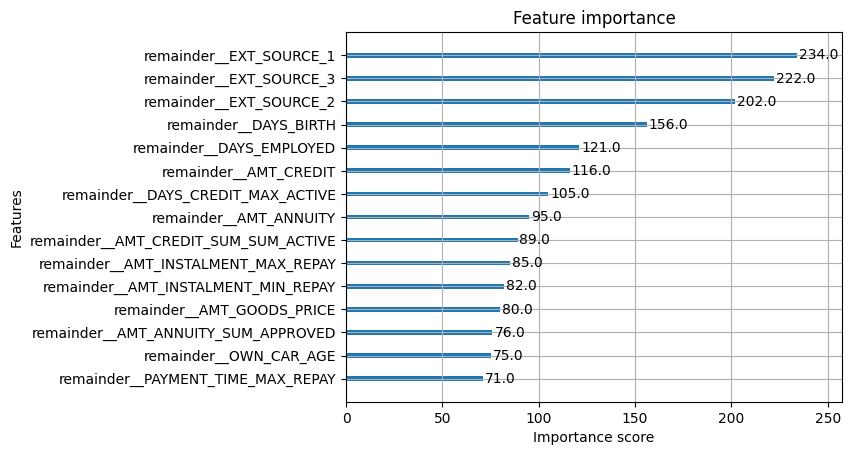

In [41]:
plot_importance(loaded_model, max_num_features=15)
plt.show()

The roc-auc score is fine but f1-score is low. One possible reason is the default threshold 0.5 didn't cutoff properly.

# Submit

In [42]:
test_data = pd.read_csv("data/application_test.csv")

test_data = test_data.merge(previous_applications, on="SK_ID_CURR", how="left", suffixes=["_main", "_previous_app"])
test_data = test_data.merge(bureau, on="SK_ID_CURR", how="left", suffixes=["_main", "_bureau"])
test_data = test_data.merge(pos_cash, on="SK_ID_CURR", how="left", suffixes=["_main", "_pos"])
test_data = test_data.merge(installment_pay, on="SK_ID_CURR", how="left", suffixes=["_main", "_repay"])
test_data = test_data.merge(bureau_balance, left_on="SK_ID_CURR", right_on="SK_ID_BUREAU", how="left", suffixes=["_main", "_bureau_bal"])

In [43]:
test_df = test_data[[_ for _ in test_data.columns if _!= "SK_ID_CURR"]]
test_df = preprocessor.transform(test_df)

In [44]:
test_y_pred = loaded_model.predict(test_df)
test_y_pred_prob = loaded_model.predict_proba(test_df)[:, 1]


final = pd.DataFrame(test_data[["SK_ID_CURR"]])
final["TARGET"] = test_y_pred_prob

final.to_csv("submission_xgboost.csv", index=False, header=True)

This version got a 0.76 AUC score.